In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from P201_Functions import *

set_dark_mode(True)

In [38]:
#  position of small mass (in cm)
# xpos = np.array([1.092,2.026,3.017,4.023,5.019,6.011,7.021])
xpos = np.array([3.993,4.915,6.003,7.108,7.923,8.920,10.024,11.024,12.005])
dxpos = np.array([0.003 for i in range(len(xpos))])

In [39]:
def outlier_removal(data, times, deviations):
    """remove outliers outside {deviations} std deviation"""
    distance_from_mean = abs(data - data.mean())
    not_outlier = distance_from_mean < deviations * data.std()
    removed_outliers = data.copy()[not_outlier]
    print(f"Removed {data.size-removed_outliers.size} outliers outside {deviations} sigma")
    return(removed_outliers, times.copy()[not_outlier])

We were measuring xpos wrong - should have been measuring between the upper edge of sm and lower edge of knife edge ring. Correct previous measurements by subtracting 8cm (~7cm from small mass diameter, ~1cm from knife edge ring diameter). Diameter small mass = 7.02cm; diameter knife edge ring = 1.422cm.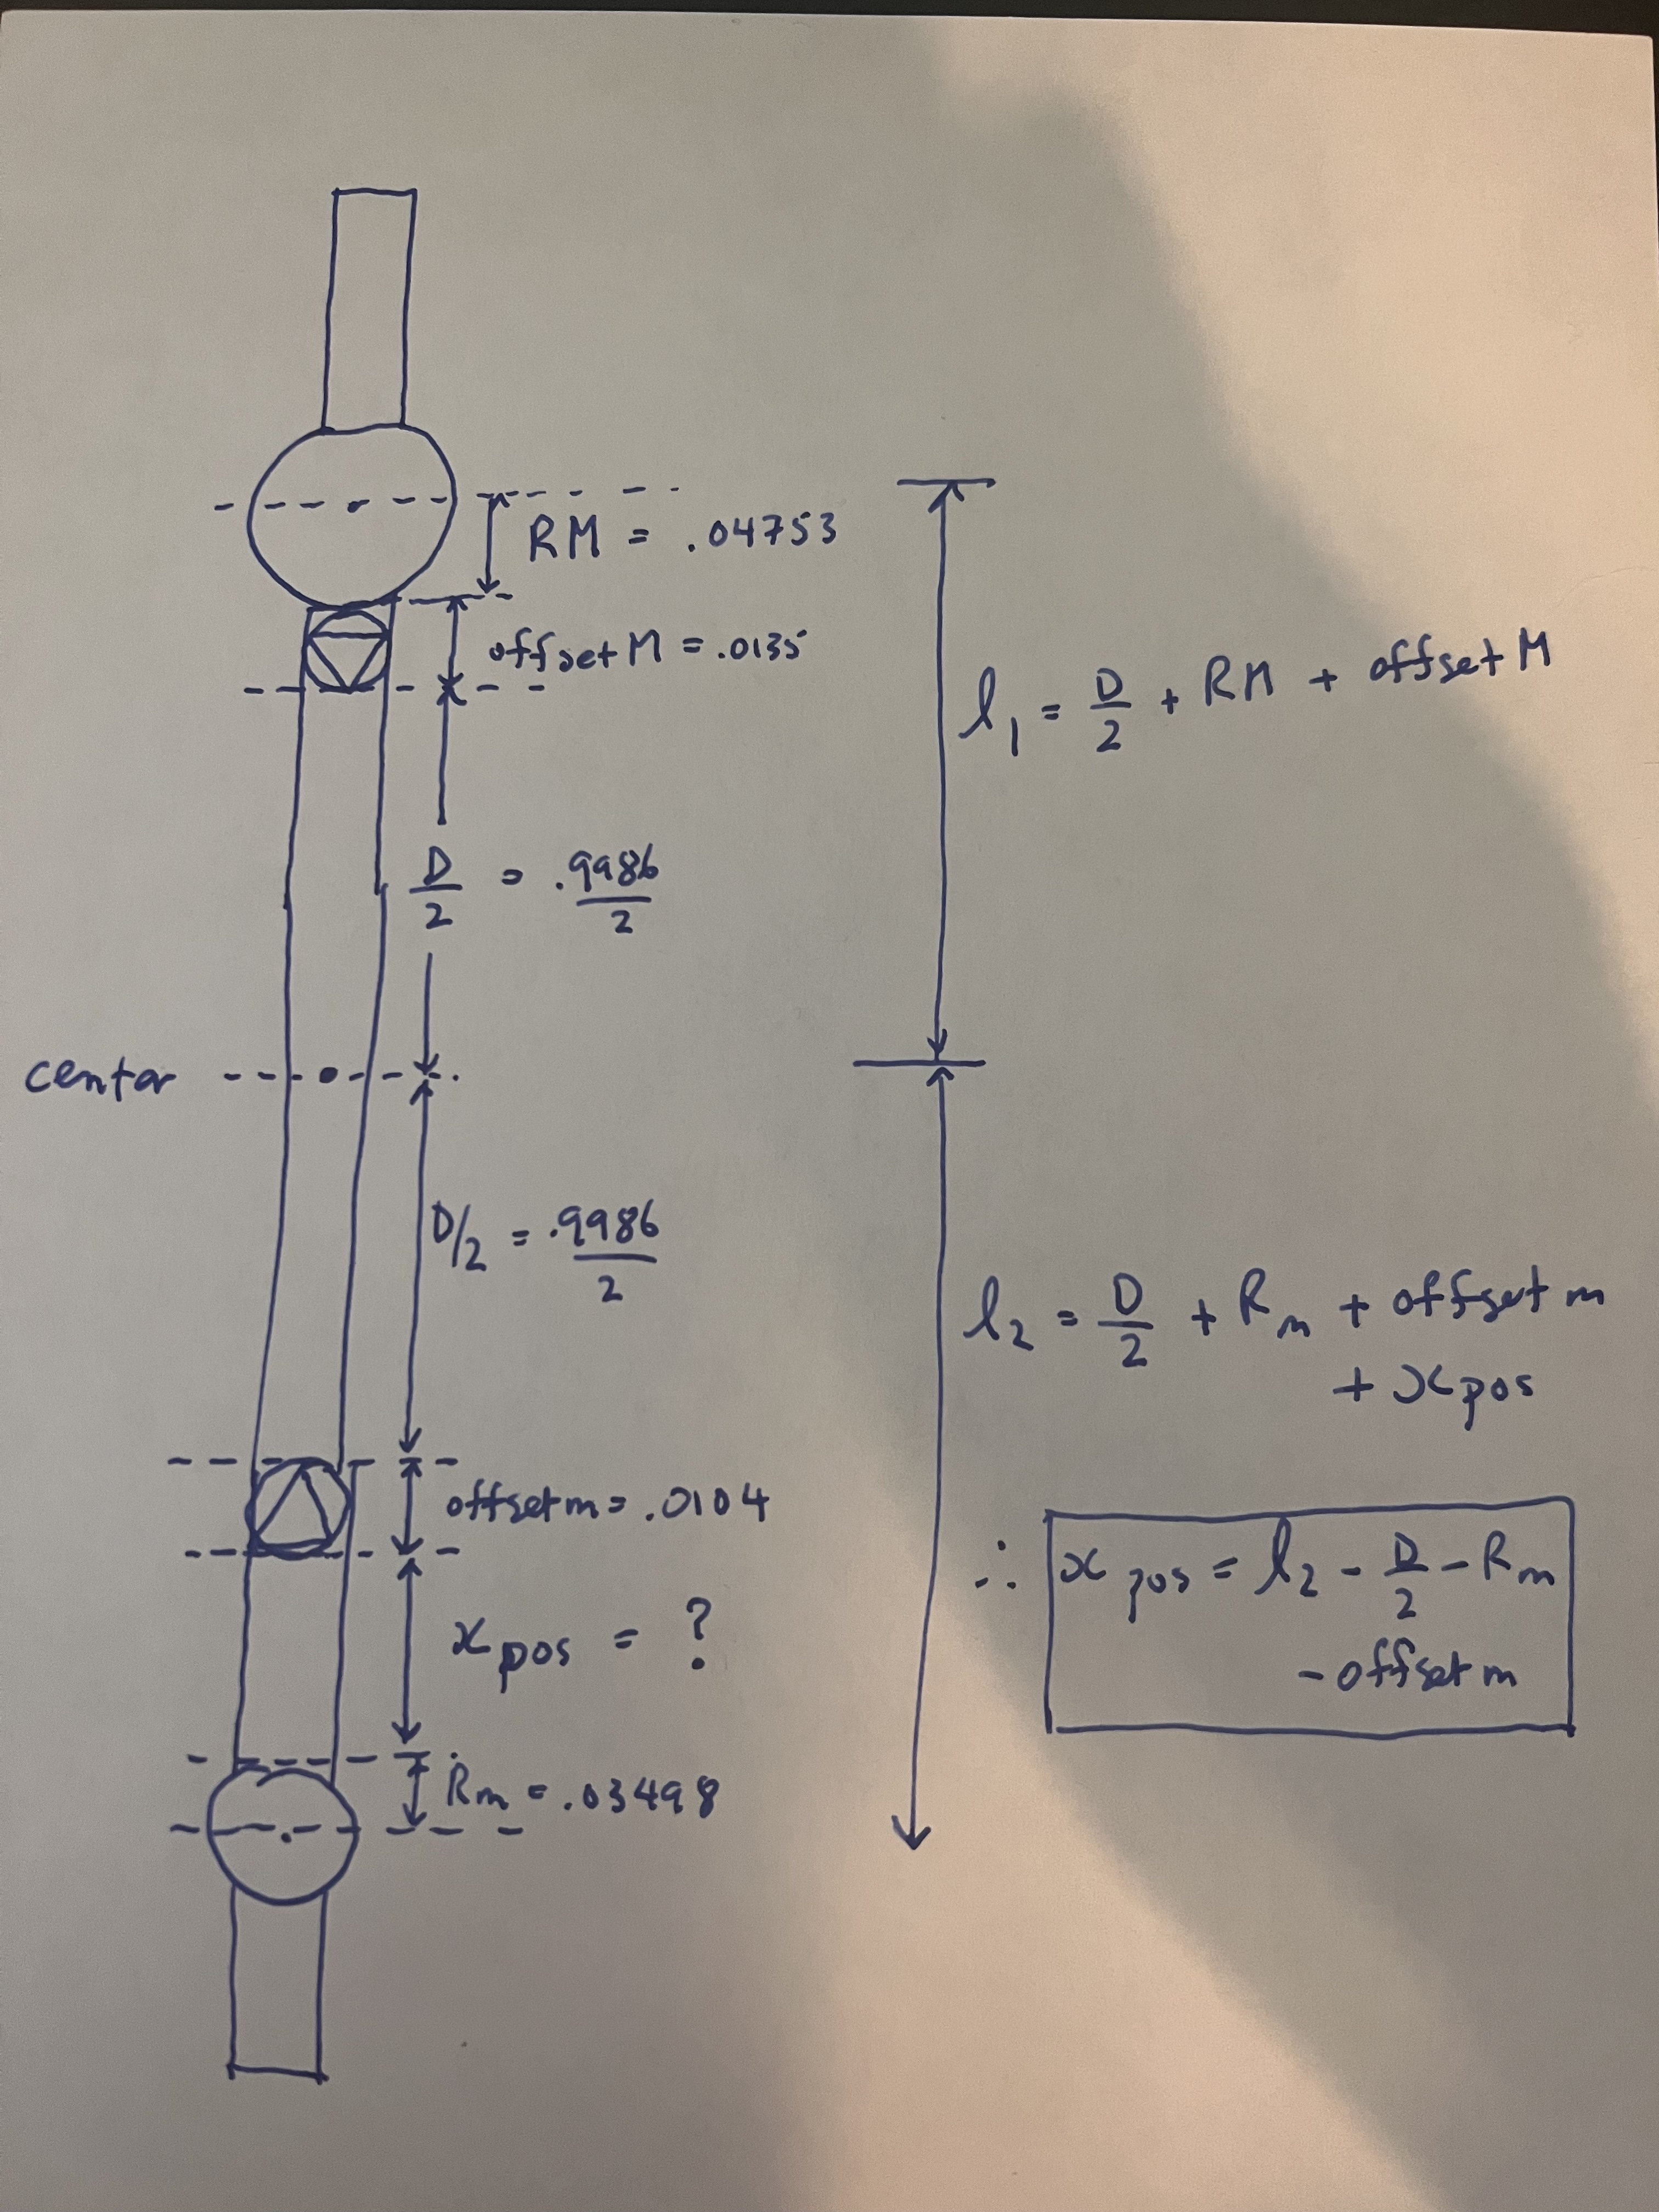

4 cm periods
Removed 31 outliers outside 1 sigma
Periodup = 2.00637 +/- 0.00000308
Removed 29 outliers outside 1 sigma
Perioddown = 2.00247 +/- 0.00000449

5 cm periods
Removed 20 outliers outside 1 sigma
Periodup = 2.00907 +/- 0.00001127
Removed 30 outliers outside 1 sigma
Perioddown = 2.00697 +/- 0.00000525

6 cm periods
Removed 20 outliers outside 1 sigma
Periodup = 2.01231 +/- 0.00001386
Removed 9 outliers outside 1 sigma
Perioddown = 2.01152 +/- 0.00000582

7 cm periods
Removed 31 outliers outside 1 sigma
Periodup = 2.01605 +/- 0.00000347
Removed 24 outliers outside 1 sigma
Perioddown = 2.01462 +/- 0.00002709

8 cm periods
Removed 19 outliers outside 1 sigma
Periodup = 2.01863 +/- 0.00000435
Removed 27 outliers outside 1 sigma
Perioddown = 2.01857 +/- 0.00000645

9 cm periods
Removed 39 outliers outside 1 sigma
Periodup = 2.02187 +/- 0.00000334
Removed 34 outliers outside 1 sigma
Perioddown = 2.02316 +/- 0.00000599

10 cm periods
Removed 17 outliers outside 1 sigma
Periodup = 2.02

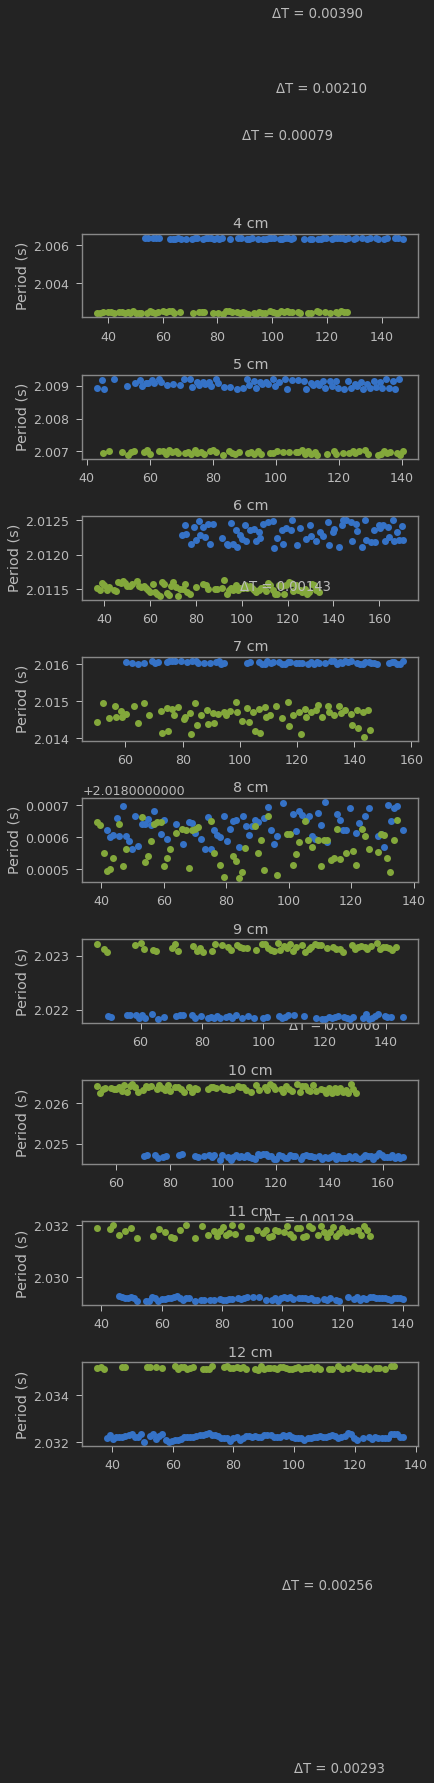

In [40]:
prefix = './KaterPendulum/data/thebrashboys/trial4/'
# prefix = './'
suffix = '.txt'

tup = []
tdown = []
dtup = []
dtdown = []

file_distances = [4,5,6,7,8,9,10,11,12]

# Generate the figure and the axes 
fig, axs = plt.subplots(nrows=9, ncols=1, figsize=(6,18))
fig.tight_layout(pad=2.0)
j = 0

for i in file_distances:
    print(str(i)+" cm periods")
    for orientation in ["SMU", "SMD"]:
        fname = prefix + orientation + "_kater_data_" + str(i) + "cm_" + suffix

        # read in .txt files
        df = pd.read_csv(fname,sep='\t')
        
        # read in times from file
        time = np.array(df)
        period = []
        # period is difference between every other time (1 cycle is 3 times)
        for k in range(2,len(time)):
            period.append(time[k]-time[k-2])

        # put period values in array
        period=np.array(period)
        # use time[2] onwards for plotting
        time=time[2:]
        
        # outlier removal
        period, time=outlier_removal(period, time, 1)
        
        # uncertainty
        sem = period.std()/np.sqrt(len(period))
        
        # plotting
        axs[j].plot(time,period,'o')
        
        match orientation:
            case "SMU":
                print ("Periodup = %0.5f +/- %0.8f" % (period.mean(),sem))
                # append period average to tup
                tup.append(period.mean())
                # append uncertainty to dtup
                dtup.append(sem)
            case "SMD":
                print ("Perioddown = %0.5f +/- %0.8f\n" % (period.mean(),sem))
                # append small mass down average to tdown
                tdown.append(period.mean())
                # append small mass down uncertainty to dtdown
                dtdown.append(sem)
    
    # difference between smu and smd average periods
    period_diff = abs(tdown[-1]-tup[-1])
    
    # plotting
    axs[j].set_ylabel('Period (s)')
#     axs[j].set_ylim(2.0, 2.033)
    axs[j].set_title(f"{i} cm")
    axs[j].text(x=100, y=2.018, s=f"ΔT = {period_diff:.5f}")
    
    j += 1
    
tup = np.array(tup)
tdown = np.array(tdown)
dtup = np.array(dtup)
dtdown = np.array(dtdown)

plt.show()

In [41]:
up = pd.DataFrame({'Xpos':xpos, 'Period':tup, 'dXpos':dxpos, 'dPeriod':dtup})
down = pd.DataFrame({'Xpos':xpos, 'Period':tdown, 'dXpos':dxpos, 'dPeriod':dtdown})

Coefficients (from curve_fit)
[1.99521738e+00 2.64842004e-03 3.61913441e-05]
Covariance Matrix (from curve_fit)
[[ 1.42486898e-06 -3.74358979e-07  2.23926298e-08]
 [-3.74358979e-07  1.02152498e-07 -6.26179590e-09]
 [ 2.23926298e-08 -6.26179590e-09  3.91703519e-10]]
Coefficients (from curve_fit)
[1.98713777e+00 3.91241626e-03 7.82334174e-06]
Covariance Matrix (from curve_fit)
[[ 4.57091674e-06 -1.20091559e-06  7.18331242e-08]
 [-1.20091559e-06  3.27690794e-07 -2.00866110e-08]
 [ 7.18331242e-08 -2.00866110e-08  1.25648039e-09]]


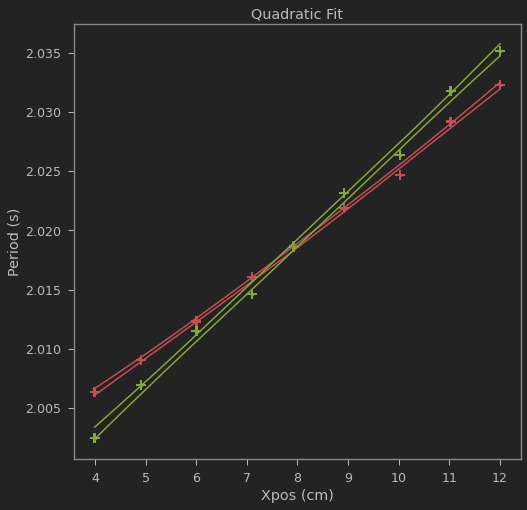

In [42]:
# Let's do linear fits using the curve_fit utility from scipy

from scipy.optimize import curve_fit

def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x + paramlist[2]*x*x

init_vals = [0.0 for x in range(3)]
x = np.array(up['Xpos'])
y = np.array(up['Period'])
poptu, pcovu = curve_fit(fitfunction,x,y,p0=init_vals)

xi = np.linspace(np.min(x),np.max(x),1000)
# xi = np.linspace(6,11,1000)
ps = np.random.multivariate_normal(poptu,pcovu,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])
loweru = np.percentile(ysample,16.0,axis=0)
upperu = np.percentile(ysample,84.0,axis=0)
middleu = (loweru+upperu)/2.0

print("Coefficients (from curve_fit)")
print (poptu)
print("Covariance Matrix (from curve_fit)")
print (pcovu)

init_vals = [0.0 for x in range(3)]
x = np.array(down['Xpos'])
y = np.array(down['Period'])
poptd, pcovd = curve_fit(fitfunction,x,y,p0=init_vals)

xi = np.linspace(np.min(x),np.max(x),1000)
# xi = np.linspace(6,11,1000)
ps = np.random.multivariate_normal(poptd,pcovd,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])
lowerd = np.percentile(ysample,16.0,axis=0)
upperd = np.percentile(ysample,84.0,axis=0)
middled = (lowerd+upperd)/2.0

print("Coefficients (from curve_fit)")
print (poptd)
print("Covariance Matrix (from curve_fit)")
print (pcovd)

fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,8)) 

axs2.errorbar(up.Xpos,up.Period,yerr=up.dPeriod,xerr=up.dXpos,fmt='r.',capsize=5, capthick=2)
axs2.errorbar(down.Xpos,down.Period,yerr=down.dPeriod,xerr=down.dXpos,fmt='g.',capsize=5, capthick=2)

#axs2.plot(xi,middleu)
axs2.plot(xi,loweru,'r')
axs2.plot(xi,upperu,'r')

#axs2.plot(xi,middle)
axs2.plot(xi,lowerd,'g')
axs2.plot(xi,upperd,'g')

axs2.set_ylabel("Period (s)")
axs2.set_xlabel("Xpos (cm)")
axs2.set_title("Quadratic Fit")
#axs2.set_xlim(3.8,4.3)
#axs2.set_ylim(2.003,2.006)

plt.show()


In [43]:
tmin = []
for i in range(len(xi)):
    if loweru[i] < upperd[i]:
        tmin.append(loweru[i])
tmin = np.array(tmin)
tmin = tmin.min()

tmax = []
for i in range(len(xi)):
    if upperu[i] > lowerd[i]:
        tmax.append(upperu[i])
tmax = np.array(tmax)
tmax = tmax.max()

tbar = (tmax+tmin)/2.0
dtbar = (tmax-tmin)/2.0

print ("Period = %0.5f +/- %0.5f" % (tbar,dtbar))
            

Period = 2.01797 +/- 0.00205


In [44]:
length = 0.9986
dlength = 0.00005

g = 4*np.pi**2*length/tbar**2
dg = g*np.sqrt((dlength/length)**2+(2*dtbar/tbar)**2)

print ("g = %0.4f +/- %0.4f" % (g,dg))

g = 9.6810 +/- 0.0197


In [45]:
# Measured distances and masses
M=1.35898 # large mass
m=0.72689 # small mass
Mbar=2.9125 # mass of bar (with small and large masses removed)
D=0.9986 # distance between knife-edge pivot points
L=1.523  # length of bar
#
g = 9.799 # value of g in Newport News
# g = 9.8144

# Distance calculations
#
# The distance between the knife edge pivot and the lower edge of the large mass is 1.35 cm
# The distance between the knife edge pivot and the lower edge of the large mass is 1.04 cm
# The radius of the large mass is 4.753 cm
# The radius of the small mass is 3.498 cm
RM = 0.04768
Rm = 0.03494
offsetM = 0.01485
offsetm = 0.01429
l1=D/2.0+RM+offsetM

# Find the value of x that satisfies the equation above

diff = 1.0E+99
olddiff = 1.0E+99
l2 = []
xpos = []
t1 = []
t2 = []
for i in range(1000):
    l2.append(D/2.0+Rm+(i/1000.0)*.12)
    xpos.append((l2[i]-offsetm-D/2-Rm-0.0000)*100) # distance from the small mass to the knife-edge, in cm.
    x=(M*l1-m*l2[i])/(M+m+Mbar)
    h2=D/2.0+x
    h1=D/2.0-x
    lhs=h1*h2;
    Icm=1.0/12.0*Mbar*L*L+Mbar*x*x+M*(l1-x)*(l1-x)+m*(l2[i]+x)*(l2[i]+x)+1/2.0*m*Rm**2 + 1.0/2*M*RM**2
    rhs=Icm/(M+m+Mbar)
    diff = lhs-rhs
    if (np.abs(diff)<olddiff):
        olddiff=diff
        index=i
    t1.append(2*np.pi*np.sqrt((h1*h1+rhs)/(g*h1)))
    t2.append(2*np.pi*np.sqrt((h2*h2+rhs)/(g*h2)))
    
#print (l2,t1,t2)

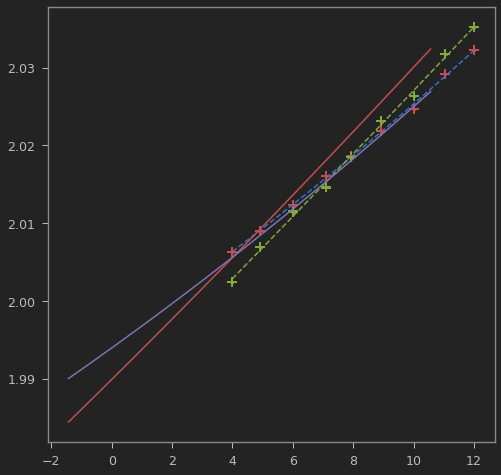

In [46]:
fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,8)) 

axs2.errorbar(up.Xpos,up.Period,yerr=up.dPeriod,xerr=up.dXpos,fmt='r.',capsize=5, capthick=2)
axs2.errorbar(down.Xpos,down.Period,yerr=down.dPeriod,xerr=down.dXpos,fmt='g.',capsize=5, capthick=2)

axs2.plot(xi,middleu,'--')
#axs2.plot(xi,loweru,'r')
#axs2.plot(xi,upperu,'r')

axs2.plot(xi,middled,'--')
#axs2.plot(xi,lowerd,'g')
#axs2.plot(xi,upperd,'g')

#axs2.set_xlim(3.8,4.3)
#axs2.set_ylim(2.003,2.006)

axs2.plot(xpos,t1,label='Small Mass Down')
axs2.plot(xpos,t2,label='Small Mass Up')

plt.show()

## So, we can see that the choice of the extra "fudge factor" offset changes for the chosen value of g.

### The next approach is to fit the data with the theoretical functions, rather than a simple quadratic polynomial.  The adjustable parameters in the fit function will be the value of g and the fudge factor.


Coefficients (from curve_fit)
[9.82732568]
Covariance Matrix (from curve_fit)
[[6.16860627e-05]]
Coefficients (from curve_fit)
[9.79422199]
Covariance Matrix (from curve_fit)
[[4.78360304e-05]]


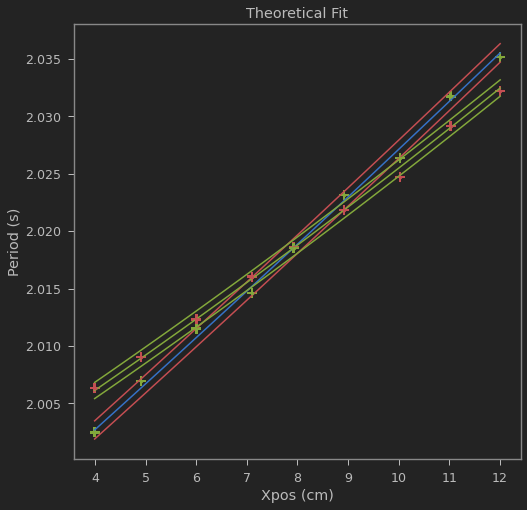

In [47]:
def theoryfitfunction1(xdata,*paramlist):
    
    M=1.35898 # large mass
    m=0.72689 # small mass
    Mbar=2.9125 # mass of bar (with small and large masses removed)
    D=0.9986 # distance between knife-edge pivot points
    L=1.523  # length of bar
    
    g = paramlist[0]
    #fudge_factor = paramlist[1]
    fudge_factor=0.0000

    # Distance calculations
    #
    # The distance between the knife edge pivot and the lower edge of the large mass is 1.35 cm
    # The distance between the knife edge pivot and the lower edge of the large mass is 1.04 cm
    # The radius of the large mass is 4.753 cm
    # The radius of the small mass is 3.498 cm
    RM = 0.04768
    Rm = 0.03494
    offsetM = 0.01485
    offsetm = 0.01429
    l1=D/2.0+RM+offsetM
    
    l2 = D/2.0+Rm+offsetm+xdata/100.0+fudge_factor
    x=(M*l1-m*l2)/(M+m+Mbar)
    
    h2=D/2.0+x
    h1=D/2.0-x
    Icm=1.0/12.0*Mbar*L*L+Mbar*x*x+M*(l1-x)*(l1-x)+m*(l2+x)*(l2+x)+1/2.0*m*Rm**2 + 1.0/2*M*RM**2
    rhs=Icm/(M+m+Mbar)
    
    t1 = 2*np.pi*np.sqrt((h1*h1+rhs)/(g*h1))
    t2 = 2*np.pi*np.sqrt((h2*h2+rhs)/(g*h2))
    
    return t1

def theoryfitfunction2(xdata,*paramlist):
    
    M=1.35898 # large mass
    m=0.72689 # small mass
    Mbar=2.9125 # mass of bar (with small and large masses removed)
    D=0.9986 # distance between knife-edge pivot points
    L=1.523  # length of bar
    
    g = paramlist[0]
    #fudge_factor = paramlist[1]
    fudge_factor=0.0000

    # Distance calculations
    #
    # The distance between the knife edge pivot and the lower edge of the large mass is 1.35 cm
    # The distance between the knife edge pivot and the lower edge of the large mass is 1.04 cm
    # The radius of the large mass is 4.753 cm
    # The radius of the small mass is 3.498 cm
    RM = 0.04768
    Rm = 0.03494
    offsetM = 0.01485
    offsetm = 0.01429
    l1=D/2.0+RM+offsetM
    
    l2 = D/2.0+Rm+offsetm+xdata/100.0+fudge_factor
    x=(M*l1-m*l2)/(M+m+Mbar)
    
    h2=D/2.0+x
    h1=D/2.0-x
    Icm=1.0/12.0*Mbar*L*L+Mbar*x*x+M*(l1-x)*(l1-x)+m*(l2+x)*(l2+x)+1/2.0*m*Rm**2 + 1.0/2*M*RM**2
    rhs=Icm/(M+m+Mbar)
    
    t1 = 2*np.pi*np.sqrt((h1*h1+rhs)/(g*h1))
    t2 = 2*np.pi*np.sqrt((h2*h2+rhs)/(g*h2))
    
    return t2

init_vals = [9.814]
x = np.array(up['Xpos'])
y = np.array(up['Period'])
poptu, pcovu = curve_fit(theoryfitfunction1,x,y,p0=init_vals)

xi = np.linspace(np.min(x),np.max(x),100)
# xi = np.linspace(1,7,1000)
ps = np.random.multivariate_normal(poptu,pcovu,10000)
ysample=np.asarray([theoryfitfunction1(xi,*pi) for pi in ps])
loweru = np.percentile(ysample,16.0,axis=0)
upperu = np.percentile(ysample,84.0,axis=0)
middleu = (loweru+upperu)/2.0

print("Coefficients (from curve_fit)")
print (poptu)
print("Covariance Matrix (from curve_fit)")
print (pcovu)

init_vals = [9.814]
x = np.array(down['Xpos'])
y = np.array(down['Period'])
poptd, pcovd = curve_fit(theoryfitfunction2,x,y,p0=init_vals)

xi = np.linspace(np.min(x),np.max(x),100)
# xi = np.linspace(1,7,1000)
ps = np.random.multivariate_normal(poptd,pcovd,10000)
ysample=np.asarray([theoryfitfunction2(xi,*pi) for pi in ps])
lowerd = np.percentile(ysample,16.0,axis=0)
upperd = np.percentile(ysample,84.0,axis=0)
middled = (lowerd+upperd)/2.0

print("Coefficients (from curve_fit)")
print (poptd)
print("Covariance Matrix (from curve_fit)")
print (pcovd)

fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,8)) 

axs2.errorbar(up.Xpos,up.Period,yerr=up.dPeriod,xerr=up.dXpos,fmt='r.',capsize=5, capthick=2)
axs2.errorbar(down.Xpos,down.Period,yerr=down.dPeriod,xerr=down.dXpos,fmt='g.',capsize=5, capthick=2)

axs2.plot(xi,middleu)
axs2.plot(xi,loweru,'r')
axs2.plot(xi,upperu,'r')

axs2.plot(xi,middled)
axs2.plot(xi,lowerd,'g')
axs2.plot(xi,upperd,'g')
axs2.set_ylabel("Period (s)")
axs2.set_xlabel("Xpos (cm)")
axs2.set_title("Theoretical Fit")
#axs2.set_xlim(3.8,4.3)
#axs2.set_ylim(2.003,2.006)

plt.show()



In [48]:
tmin = []
for i in range(len(xi)):
    if loweru[i] < upperd[i]:
        tmin.append(loweru[i])
tmin = np.array(tmin)
tmin = tmin.min()

tmax = []
for i in range(len(xi)):
    if upperu[i] > lowerd[i]:
        tmax.append(upperu[i])
tmax = np.array(tmax)
tmax = tmax.max()

tbar = (tmax+tmin)/2.0
dtbar = (tmax-tmin)/2.0

print ("Period = %0.5f +/- %0.5f" % (tbar,dtbar))
            

Period = 2.01911 +/- 0.01722


In [49]:
length = 0.9986
dlength = 0.00005

g = 4*np.pi**2*length/tbar**2
dg = g*np.sqrt((dlength/length)**2+(2*dtbar/tbar)**2)

print ("g = %0.4f +/- %0.4f" % (g,dg))

g = 9.6701 +/- 0.1649
